Этот пример демонстрирует применение алгоритма DQN для задачи обучения агента на среде CartPole-v1 из пакета Gymnasium на базе PyTorch.


## Задача

Агент должен принять решение между двумя действиями - перемещением тележки влево или вправо - так, чтобы прикрепленный к ней шест остался в вертикальном положении.

В глубоком Q-обучении нейронная сеть обучается выводить значения $Q(s, a)$ для каждого действия, зная входное состояние $s$. Действие агента $a$ выбирается на основе порождаемых значений $Q(s, a)$, следуя $\varepsilon$-жадной стратегии. Архитектура DQN будет с двумя скрытыми слоями.

Q-обучение – это алгоритм обучения с разделенной стратегией, в котором Q-функция обновляется по формуле:
$$Q(s, a) \gets Q(s, a) + \alpha \big(r + \gamma \max_{a'}Q(s', a') - Q(s, a) \big)$$
где $s'$ - состояние в которое переходит среда из состояния $s$ после действия $a$, $r$ – полученное при этом вознаграждение, $\alpha$ - скорость обучения, $\gamma$ – коэффициент дисконтирования.

Наличие члена $\max_{a'}Q(s', a')$ означает, что поведенческая стратегия жадная, т.е для генерации обучающих данных выбирается действие в состоянии $s'$ с наибольшим значением Q-функции. DQN обучается минимизировать член ошибки:
$$\delta = r + \gamma \max_{a'}Q(s') - Q(s)$$

Таким образом, наша цель – найти оптимальные веса сети, при которых достигается наилучшая аппроксимация функции ценности состояний $Q(s, a)$ для всех возможных действий. Минимизируемая функция потерь – среднеквадратическая ошибка между истинным значением и его оценкой.

## Реализация

Метод `__init__` класса `DQN` принимает четыре параметра: количество состояний во входном слое, количество действий в выходном слое, количество нейронов в скрытом слое и скорость обучения. Он инициализирует нейронную сеть с функцией активации `ReLU`. Сеть имеет `n_state` входов и порождает `n_action` выходов – предсказанные ценности состояний при выборе каждого действия. В качестве оптимизатора используется алгоритм `Adam`, а в качестве функции потерь – среднеквадратическая ошибка.

Функция `update(self, s, y)` производит обновление сети: зная исходное состояние и соответствующее ему целевое значение, метод вычисляет функцию потерь и градиенты. Затем модель обновляется методом обратного распространения.

### Aлгоритм
- использовать модель нейронной сети для оценки значений Q старого состояния;
- использовать модель нейронной сети для оценки значений Q нового состояния;
- обновить целевое значение Q для действия с учетом вознаграждения и новых значений Q;
- обучить нейронную сеть, приняв в качестве входа старое состояние, а в качестве выхода целевые значения Q.

Реализация алгоритма дана в функции `q_learning(env, estimator, n_episode, gamma=1.0, epsilon=0.1, epsilon_decay=.99)`, при вызове выполняем следующее:
- в каждом эпизоде создаем $\varepsilon$-жадную стратегию, причем $\varepsilon$ затухает с коэффициентом 0.99 (если в первом эпизоде $\varepsilon$ было равно 0.1, то во втором будет равно 0.099). Задается также нижний предел $\varepsilon$, равный 0.01;
- выполняем эпизод обучения - на каждом шаге выбираем действие $a$ в состоянии $s$ следуя $\varepsilon$-жадной стратегии. Значения Q-функции `q_values` в предыдущем состоянии вычисляются с использованием метода `predict` класса `DQN`;
- вычисляем значение Q-функции `q_values_next` для нового состояния $s'$, затем вычисляем целевое значение, обновляя старые значения `q_values` по формуле $Q(s, a) = r + \gamma \max_{a'}Q(s', a')$
- используем пример (s, Q(s)) для обучения нейронной сети. Отметим, что Q(s) включает ценности для всех действий;

In [1]:
import gymnasium as gym
import math
import random
import matplotlib
import matplotlib.pyplot as plt
from collections import namedtuple, deque
from itertools import count
from tqdm import tqdm

import numpy as np

import gym
import torch
from torch.autograd import Variable

import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

is_ipython = 'inline' in matplotlib.get_backend()
if is_ipython:
    from IPython import display
    
plt.ion()

In [2]:
class DQN():
    def __init__(self, n_state, n_action, n_hidden=50, lr=0.05):
        self.criterion = torch.nn.MSELoss() 
        self.model = torch.nn.Sequential(
            torch.nn.Linear(n_state, n_hidden), 
            torch.nn.ReLU(), 
            torch.nn.Linear(n_hidden, n_hidden),
            torch.nn.ReLU(), 
            torch.nn.Linear(n_hidden, n_action)
            )
        self.optimizer = torch.optim.Adam(self.model.parameters(), lr)
    
    def update(self, s, y):
        """
        Обновляет веса DQN, получив обучающий пример
        @param s: состояние
        @param y: целевое значение
        """
        y_pred = self.model(torch.Tensor(s))
        loss = self.criterion(y_pred, Variable(torch.Tensor(y))) 
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()
        
    def predict(self, s):
        """
        Вычисляет значения Q-функции состояния для всех действий, применяя обученную модель
        @param s: входное состояние
        @return: значения Q для всех действий
        """
        with torch.no_grad():
            return self.model(torch.Tensor(s))

Определим $\varepsilon$-жадную стратегию

In [3]:
def gen_epsilon_greedy_policy(estimator, epsilon, n_action):
    def policy_function(state):
        if random.random() < epsilon:
            return random.randint(0, n_action - 1) 
        else:
            q_values = estimator.predict(state) 
        return torch.argmax(q_values).item()
    return policy_function

Зададим среду и определим алгоритм Q-обучения с применением DQN:

In [4]:
env = gym.make("CartPole-v1")

In [33]:
def q_learning(env, estimator, n_episode, gamma=1.0, epsilon=0.1, epsilon_decay=.99):
    """
    Глубокое Q-обучение с применением DQN
    @param env: имя окружающей среды Gym
    @param estimator: объект класса Estimator
    @param n_episode: количество эпизодов
    @param gamma: коэффициент обесценивания
    @param epsilon: параметр ε-жадной стратегии
    @param epsilon_decay: коэффициент затухания epsilon
    """
    for episode in tqdm(range(n_episode)):
        policy = gen_epsilon_greedy_policy(estimator, epsilon, n_action) 
        state = env.reset()
        is_done = False
        while not is_done:
            action = policy(state)
            next_state, reward, is_done, _ = env.step(action) 
            total_reward_episode[episode] += reward
            
            q_values = estimator.predict(state).tolist()
            
            if is_done:
                q_values[action] = reward 
                estimator.update(state, q_values) 
                break
            q_values_next = estimator.predict(next_state) 
            q_values[action] = reward + gamma * torch.max(q_values_next).item()
            estimator.update(state, q_values) 
            state = next_state
        if episode < 100:
            mean_rewards[episode] = np.mean(total_reward_episode[:episode])
        else:
            mean_rewards[episode] = np.mean(total_reward_episode[episode-100:episode])    
        
        epsilon = max(epsilon * epsilon_decay, 0.01)

In [34]:
# вспомогательная функция для отрисовки результатов
def plot_durations(show_result=False):
    plt.figure(1);
#     преобразуем массив длительностей в тензор 
    durations_t = torch.tensor(total_reward_episode, dtype=torch.float)
    if show_result:
        plt.title('Result');
    else:
        plt.clf();  # Очищаем график
        plt.title('Training...');
        
    plt.xlabel('Episode');
    plt.ylabel('Duration');
    plt.plot(durations_t.numpy());
    # Отрисовываем среднюю оценку за 100 эпизодов
    if len(durations_t) >= 100:
        means = durations_t.unfold(0, 100, 1).mean(1).view(-1)
        means = torch.cat((torch.zeros(99), means))
        plt.plot(means.numpy());

    plt.pause(0.001)  # pause a bit so that plots are updated
    if is_ipython:
        if not show_result:
            display.display(plt.gcf());
            display.clear_output(wait=True);
        else:
            display.display(plt.gcf());

100%|██████████████████████████████████████████████████████████████████████████████████████| 500/500 [00:34<00:00, 14.35it/s]

Complete


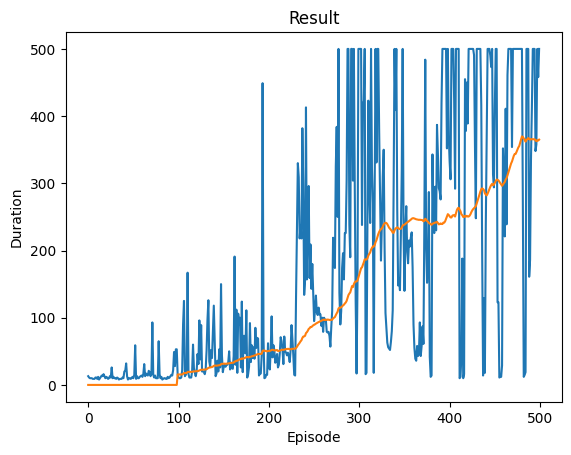

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

In [35]:
n_state = env.observation_space.shape[0] 
n_action = env.action_space.n
n_hidden = 128
lr = 0.001
dqn = DQN(n_state, n_action, n_hidden, lr)

n_episode = 500
total_reward_episode = [0] * n_episode
mean_rewards = [0] * n_episode


q_learning(env, dqn, n_episode, gamma=.99, epsilon=.3)

print('Complete')
# отрисовываем финальный график
plot_durations(show_result=True)
plt.ioff();
plt.show();